<a href="https://colab.research.google.com/github/ali1810/Big-DATA-week1-/blob/master/Solubility_20_05_11_Delaney_data_features_fingerprint_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Use seaborn for pairplot ...
!pip install -q seaborn

In [ ]:
# Importing required library ...
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
## Importing tensorflow...
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


In [ ]:
### Installation of condacolab to install rdkit ....
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:40
🔁 Restarting kernel...


In [1]:
### Installing RDKIT 

#!mamba install -c conda-forge rdkit

In [ ]:
## Mount drive to access the dataset from google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/delaney.csv')


In [ ]:
data.isnull().values.any().sum()

0

In [ ]:
data['SMILES'].isnull().any().sum()
#check_for_nan = data['SMILES'].isnull()
#print (check_for_nan)

0

In [ ]:
data.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


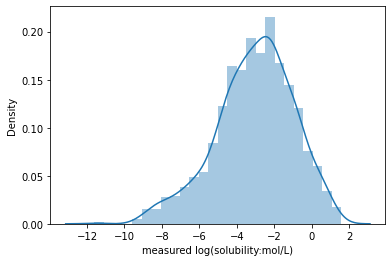

In [ ]:
## WE can see the distribution of Solubility 
import seaborn as sns
sns.distplot(data["measured log(solubility:mol/L)"])

In [ ]:
### selecting the range of LogS from the dataframe ....
#df_new = data.loc[data['measured log(solubility:mol/L)'].between(-6,2,inclusive=False)]
#df['two'].between(-0.5, 0.5, inclusive=False)

In [ ]:
#print(len(df_new))

In [ ]:

smiles_array=data.SMILES

#smiles_array1=data1.Smiles

In [ ]:
print(type(smiles_array))

<class 'pandas.core.series.Series'>


In [ ]:
print(len(smiles_array))

1144


In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Fingerprints import FingerprintMols

from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import Crippen

In [ ]:
#Turning SMILES into Explicit Bit Vectors (RDKit prefered format)
mols = [Chem.rdmolfiles.MolFromSmiles(SMILES_string) for SMILES_string in smiles_array]


#Convert training molecules into training fingerprints
bi = {}
fingerprints = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo= bi, nBits=512) for m in mols]

#Convert training fingerprints into binary, and put all training binaries into arrays
import numpy as np 

fingerprints_array = []
for fingerprint in fingerprints:
        array = np.zeros((1,), dtype= int)
        DataStructs.ConvertToNumpyArray(fingerprint, array)
        fingerprints_array.append(array)

In [ ]:
### Write a function to calculate these values....

def getAromaticProportion(m):
    aromatic_list = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    aromatic = 0
    for i in aromatic_list:
        if i:
            aromatic += 1
    heavy_atom = Lipinski.HeavyAtomCount(m)
    return aromatic / heavy_atom


def generate(smiles):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1, 1)
    i = 0
    for mol in moldata:

        desc_MolLogP = Crippen.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Lipinski.NumRotatableBonds(mol)
        desc_AromaticProportion = getAromaticProportion(mol)
        desc_Ringcount        =   Descriptors.RingCount(mol)
        desc_TPSA = Descriptors.TPSA(mol)
        desc_Hdonrs=Lipinski.NumHDonors(mol)
        desc_SaturatedRings = Lipinski.NumSaturatedRings(mol)   
        desc_AliphaticRings = Lipinski.NumAliphaticRings(mol) 
        desc_HAcceptors = Lipinski.NumHAcceptors(mol)
        desc_Heteroatoms = Lipinski.NumHeteroatoms(mol)
        #desc_molMR=Descriptors.MolMR(mol)
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds,
                        desc_AromaticProportion,desc_Ringcount,desc_TPSA,desc_Hdonrs,desc_SaturatedRings,desc_AliphaticRings,desc_HAcceptors,desc_Heteroatoms])

        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i + 1

    columnNames = ["MolLogP", "MolWt", "NumRotatableBonds", "AromaticProportion","Ring_Count","TPSA","H_donors","Saturated_Rings","AliphaticRings","H_Acceptors","Heteroatoms"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors


In [ ]:
#!conda install -y boost-cpp boost py-boost

In [ ]:
import numpy as np
df=generate(smiles_array)
#descriptors =generate(smiles_array)
print(df)

      MolLogP    MolWt  NumRotatableBonds  AromaticProportion  Ring_Count  \
0     2.59540  167.850                0.0            0.000000         0.0   
1     2.37650  133.405                0.0            0.000000         0.0   
2     2.59380  167.850                1.0            0.000000         0.0   
3     2.02890  133.405                1.0            0.000000         0.0   
4     2.91890  187.375                1.0            0.000000         0.0   
...       ...      ...                ...                 ...         ...   
1139  1.98820  287.343                8.0            0.000000         0.0   
1140  3.42130  286.114                2.0            0.333333         2.0   
1141  3.60960  308.333                4.0            0.695652         3.0   
1142  2.56214  354.815                3.0            0.521739         2.0   
1143  2.02164  179.219                1.0            0.461538         1.0   

        TPSA  H_donors  Saturated_Rings  AliphaticRings  H_Acceptors  \
0  

In [ ]:
## Taking out the solubility from the dataset... 
Y = data.iloc[:,2].rename("LogS")
Y

0      -2.794
1      -2.232
2      -2.549
3      -1.961
4      -3.077
        ...  
1139   -1.446
1140   -4.377
1141   -3.913
1142   -3.642
1143   -2.688
Name: LogS, Length: 1144, dtype: float64

In [ ]:
dataset = pd.concat([df,Y],axis=1)

In [ ]:
dataset.isnull().values.any().sum()

0

In [ ]:
dataset = dataset.dropna()

In [ ]:
dataset.isnull().values.any().sum()

0

In [ ]:
##Normalization
##In the table of statistics it's easy to see how different the ranges of each feature are:

dataset.describe().transpose()[['mean', 'std']]

,mean,std
MolLogP,2.449133,1.866003
MolWt,204.631675,102.620500
NumRotatableBonds,2.173951,2.627398
AromaticProportion,0.364932,0.343305
Ring_Count,1.396853,1.316105
TPSA,35.058829,35.694546
H_donors,0.708916,1.108335
Saturated_Rings,0.312937,0.838680
AliphaticRings,0.462413,1.050094
H_Acceptors,2.116259,2.165816


In [ ]:
fingerprints_array=pd.DataFrame(fingerprints_array)
df1=pd.concat([fingerprints_array,dataset],axis=1)
#df1#df1 = np.append(fingerprints_array, df, axis = 1)
print(df1.shape)

(1144, 524)


In [ ]:
## Split the data into training and test sets
## Now, split the dataset into a training set and a test set. We will use the test set in the final evaluation of our models.

train_dataset = df1.sample(frac=0.8, random_state=0)
test_dataset = df1.drop(train_dataset.index)

In [ ]:
## Split features from labels
#Separate the target value—the "label"—from the features. This label is the solubility 
#of the compound that we will train the model to predict for new compound .....

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('LogS')
test_labels = test_features.pop('LogS')

In [ ]:
train_features = train_features.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
test_features = test_features.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
train_labels = train_labels.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
test_labels = test_labels.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [ ]:
print(type(train_features))
print(type(train_labels))
print(type(test_features))
print(type(test_labels))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [ ]:
print(len(train_features))
print(len(train_labels))
print(len(test_features))
print(len(test_labels))

915
915
229
229


In [ ]:
import numpy as np
#from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers
import tensorflow as tf
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Merge inputs and targets
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)
num_folds=5
batch_size=20
no_epochs=35
mae_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)


# K-fold Cross Validation model evaluation
fold_var = 1
for train, test in kfold.split(inputs, targets):
  # Define the model architecture
  network = models.Sequential()
  network.add(layers.Dense(512, activation='relu', input_shape=(523,)))
  #network.add(layers.Dense(512, activation='relu'))
 
  #network.add(Dropout(0.1))
  network.add(layers.Dense(256, activation='relu'))
  #network.add(Dropout(0.1))
  network.add(layers.Dense(128, activation='relu'))
  #network.add(Dropout(0.1))
  network.add(layers.Dense(64, activation='relu'))
  network.add(layers.Dense(32, activation='relu'))
  #network.add(layers.Dense(16, activation='relu'))

  network.add(layers.Dense(1))
#
# Configure the network with optimizer, loss function and accuracy
#tf.optimizers.Adam(learning_rate=0.1)

#
  network.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['mae'])

#network.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                #loss='mse',
               # metrics=['mae'])
  #checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_mae', verbose=1,save_best_only=True, mode='max')
  #callbacks_list = [checkpoint]             


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')

  # Fit data to model
  history = network.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs
              )

  # Generate generalization metrics
  scores = network.evaluate(inputs[test], targets[test], verbose=0)
  #print(f'Score for fold {fold_var}: {network.metrics_names[0]} of {scores[0]}; {network.metrics_names[1]} of {scores[1]*100}%')
  mae_per_fold.append(scores[1] )
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_var = fold_var + 1
  # == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(mae_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Absolute Error: {mae_per_fold[i]}%')
  print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Absolute Error: {np.mean(mae_per_fold)} (+- {np.std(mae_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/35
46/46 [==============================] - 1s 6ms/step - loss: 171.2818 - mae: 2.7832
Epoch 2/35
46/46 [==============================] - 0s 7ms/step - loss: 1.6936 - mae: 0.8365
Epoch 3/35
46/46 [==============================] - 0s 7ms/step - loss: 0.3357 - mae: 0.4261
Epoch 4/35
46/46 [==============================] - 0s 7ms/step - loss: 0.2092 - mae: 0.3439
Epoch 5/35
46/46 [==============================] - 0s 7ms/step - loss: 0.1445 - mae: 0.2872
Epoch 6/35
46/46 [==============================] - 0s 6ms/step - loss: 0.1299 - mae: 0.2736
Epoch 7/35
46/46 [==============================] - 0s 6ms/step - loss: 0.1539 - mae: 0.3017
Epoch 8/35
46/46 [==============================] - 0s 6ms/step - loss: 0.1184 - mae: 0.2684
Epoch 9/35
46/46 [==============================] - 0s 6ms/step - loss: 0.0889 - mae: 0.2286
Epoch 10/35
46/46 [==============================] - 0s 6ms/step

In [ ]:
# Importing required library ...
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
network = models.Sequential()
  #network.add(layers.Dense(1024, activation='relu', input_shape=(11,)))
network.add(layers.Dense(512, activation='relu',input_shape=(523,)))
 
  #network.add(Dropout(0.1))
network.add(layers.Dense(256, activation='relu'))
  #network.add(Dropout(0.1))
network.add(layers.Dense(128, activation='relu'))
  #network.add(Dropout(0.1))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
  #network.add(layers.Dense(16, activation='relu'))

network.add(layers.Dense(1))
#
# Configure the network with optimizer, loss function and accuracy
#tf.optimizers.Adam(learning_rate=0.1)

#
network.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['mae'])

  # Fit data to model
history = network.fit(train_features, train_labels,
                    validation_data=(test_features, test_labels),
                    epochs=35,
                    batch_size=20)

Epoch 1/35
46/46 [==============================] - 1s 12ms/step - loss: 94.8519 - mae: 2.7170 - val_loss: 0.5970 - val_mae: 0.6308
Epoch 2/35
46/46 [==============================] - 0s 8ms/step - loss: 0.3421 - mae: 0.4502 - val_loss: 0.1947 - val_mae: 0.3301
Epoch 3/35
46/46 [==============================] - 0s 8ms/step - loss: 0.2910 - mae: 0.4060 - val_loss: 0.4743 - val_mae: 0.5353
Epoch 4/35
46/46 [==============================] - 0s 8ms/step - loss: 0.1890 - mae: 0.3267 - val_loss: 0.1558 - val_mae: 0.2844
Epoch 5/35
46/46 [==============================] - 0s 9ms/step - loss: 0.1262 - mae: 0.2623 - val_loss: 0.1651 - val_mae: 0.2999
Epoch 6/35
46/46 [==============================] - 0s 9ms/step - loss: 0.1180 - mae: 0.2500 - val_loss: 0.3211 - val_mae: 0.4280
Epoch 7/35
46/46 [==============================] - 0s 9ms/step - loss: 0.1199 - mae: 0.2500 - val_loss: 0.1671 - val_mae: 0.2981
Epoch 8/35
46/46 [==============================] - 0s 8ms/step - loss: 0.1265 - mae: 0.

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 512)               268288    
                                                                 
 dense_97 (Dense)            (None, 256)               131328    
                                                                 
 dense_98 (Dense)            (None, 128)               32896     
                                                                 
 dense_99 (Dense)            (None, 64)                8256      
                                                                 
 dense_100 (Dense)           (None, 32)                2080      
                                                                 
 dense_101 (Dense)           (None, 1)                 33        
                                                                 
Total params: 442,881
Trainable params: 442,881
Non-t

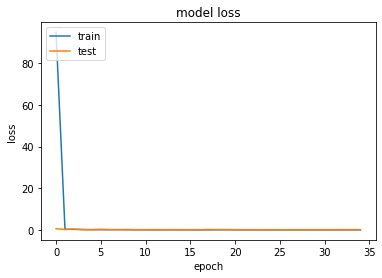

Mean squared error (MSE): 0.15
Coefficient of determination (R^2): 0.95


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print(network.summary())

#create callback
#filepath = '/content/drive/MyDrive/my_best_model_14_05_11.hdf5'

#plot the training history
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.legend()
#plt.xlabel('Epochs')
#plt.ylabel('Mean Squared Error')
#plt.savefig('model_training_history')
#plt.show()

#Load and evaluate the best model version
#model = load_model(filepath)
Y_test_predicted = network.predict(test_features)
print('Mean squared error (MSE): %.2f'%  mean_squared_error(test_labels, Y_test_predicted))
print('Coefficient of determination (R^2): %.2f'% r2_score(test_labels,Y_test_predicted))


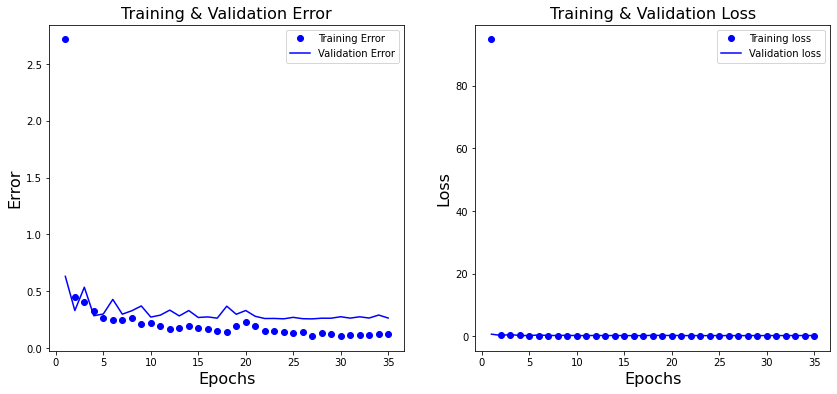

In [ ]:
##Evaluating the Model Accuracy and Loss using Learning Curve
##The output of the training is a history object which records the loss and accuracy metric after each epoch. 
##The loss and accuracy metric (mae) is measured for training and validation data set after each epoch. 
##The same is plotted to understand aspects such as overfitting and select the most appropriate model. 
##Below is the code for plotting the learning curve.

import matplotlib.pyplot as plt
 
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
mae = history_dict['mae']
val_mae = history_dict['val_mae']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy (MAE) vs Epochs
#
ax[0].plot(epochs, mae, 'bo', label='Training Error')
ax[0].plot(epochs, val_mae, 'b', label='Validation Error')
ax[0].set_title('Training & Validation Error', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Error', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
Y_test_predited=network.predict(test_features)

In [ ]:
print(len(Y_test_predited))

229


In [ ]:
test_labels=test_labels.to_numpy(dtype ='float32')
train_labels=train_labels.to_numpy(dtype ='float32')

AttributeError: ignored

In [ ]:
print(np.concatenate((Y_test_predited.reshape(len(Y_test_predited),1), test_labels.reshape(len(test_labels),1)),1))

[[-3.8067412  -4.008     ]
 [-1.6455659  -1.374     ]
 [-1.7051997  -1.794     ]
 [-2.7322016  -2.697     ]
 [-2.2908397  -2.281     ]
 [-3.363729   -3.375     ]
 [-4.4117174  -4.147     ]
 [-3.3764737  -3.542     ]
 [-1.668779   -1.655     ]
 [-3.1368792  -3.003     ]
 [-2.7540476  -2.648     ]
 [-5.0837426  -4.94      ]
 [-2.3589964  -2.364     ]
 [-1.4493033  -1.199     ]
 [-5.398817   -4.889     ]
 [-4.7503824  -4.478     ]
 [-2.9214573  -3.08      ]
 [-2.6268396  -2.721     ]
 [-1.0573957  -1.042     ]
 [-1.9688092  -2.01      ]
 [-4.341037   -4.231     ]
 [-8.611479   -8.468     ]
 [-6.044342   -6.079     ]
 [-8.071162   -7.898     ]
 [-6.110014   -6.155     ]
 [-2.7626703  -2.922     ]
 [-7.4862647  -7.343     ]
 [-2.4200153  -2.584     ]
 [-2.6755931  -2.938     ]
 [-6.3671627  -6.312     ]
 [-4.806587   -4.335     ]
 [-5.6457586  -5.686     ]
 [-5.645759   -5.686     ]
 [-5.8472934  -5.762     ]
 [-5.6357813  -5.604     ]
 [-0.55587393 -1.647     ]
 [-2.7920876  -2.604     ]
 

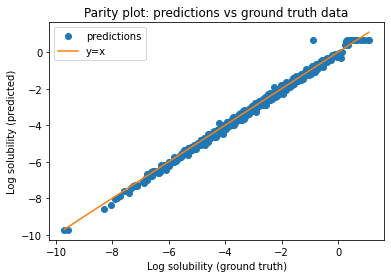

In [ ]:
preds = network.predict(train_features)
x_y_line = np.linspace(min(train_labels.flatten()), max(train_labels.flatten()), 500)
plt.plot(train_labels.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y=x')
plt.xlabel("Log solubility (ground truth)")
plt.ylabel("Log solubility (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

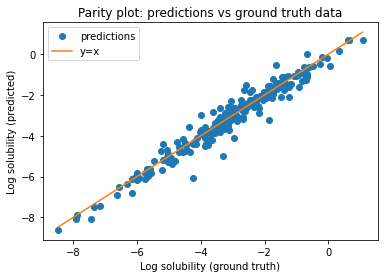

In [ ]:
preds = network.predict(test_features)
x_y_line = np.linspace(min(test_labels.flatten()), max(test_labels.flatten()), 500)
plt.plot(test_labels.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y=x')
plt.xlabel("Log solubility (ground truth)")
plt.ylabel("Log solubility (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

In [ ]:
from sklearn.metrics import r2_score
r2_score(test_labels, Y_test_predited)
print('Mean squared error (MSE): %.2f'% mean_squared_error(test_labels, Y_test_predited))
print('Coefficient of determination (R^2): %.2f'% r2_score(test_labels,Y_test_predited))




Mean squared error (MSE): 0.15
Coefficient of determination (R^2): 0.95
